In [15]:
import os
import numpy as np
import pandas as pd
import compress_json
from glob import glob
from typing import Dict
import matplotlib.pyplot as plt
from humanize import naturaldelta
from tqdm.auto import tqdm, trange
from time import perf_counter, sleep
from sanitize_ml_labels import sanitize_ml_labels

# Load the data

In [16]:
files = [
    path
    for path in glob('./graphs/results/**/*.csv', recursive=True)
    if os.path.getsize(path) > 0 and "node2"not in path.lower()
]

In [26]:
reports = pd.DataFrame([
    compress_json.load(report_path)
    for report_path in glob("./graphs/**/report.json", recursive=True)
])

In [27]:
reports

unique_node_types_number edges_number has_edge_types has_weights  \
0                         0    292218600          false       false   
1                         0         6108          false       false   
2                         0    956383622          false       false   
3                         0      9014630          false       false   
4                         0     28967291          false       false   
5                         0     62767166          false       false   
6                         0        17927          false       false   
7                         0     30949369          false       false   
8                         0       181622          false       false   
9                         0      7564901          false       false   
10                        0      1089076          false        true   
11                        0     24669643          false       false   
12                        0      4186390          false       false   

   self_loops_number singletons         degree_mean unique_edge_types_number  \
0                  0          0   299.4257784882112                        0   
1                  0          0  25.239669421487605                        0   
2                298          0   33.55248144916645                        0   
3                  0          0   4.835051728863413                        0   
4              45101          0   642.2760249218421                        0   
5                  0          0   26.08173921570909                        0   
6                105          0  10.065693430656934                        0   
7                481          0   83.81389145405849                        0   
8                  0          0  168.79368029739777                        0   
9                  7          0   8.440096842034798                        0   
10                 0          0   67.75810365208736                        0   
11             22283          0  1107.1060000897546                        0   
12                 0          0  47.152527482429264                        0   

   nodes_number                density directed           self_loops_rate  \
0        975930    0.08989636124273549    false                         0   
1           242    0.10472891876135935    false                         0   
2      28504110     0.9563488357674478    false  0.0000003115904467046593   
3       1864433   0.006090947317817511    false                         0   
4         45101    0.01424115354593885    false     0.0015569629897390128   
5       2406556    0.03314946193105199    false                         0   
6          1781   0.005654883949807266    false      0.005857087075361187   
7        369263   0.009639122489592361    false    0.00001554151233261008   
8          1076    0.15701737702083512    false                         0   
9        896305    0.03728896682469837    false  0.0000009253260551592149   
10        16073   0.004215909883778456    false                         0   
11        22283    0.04968611435642018    false     0.0009032558760578741   
12        88784  0.0011669241301848735    false                         0   

   has_node_types  
0           false  
1           false  
2           false  
3           false  
4           false  
5           false  
6           false  
7           false  
8           false  
9           false  
10          false  
11          false  
12          false

In [17]:
execs_type = {}
result = pd.DataFrame()
for file in files:
    # From the path extract the infos
    *_, graph, library, task = file.split("/")
    # Load the file
    df = pd.read_csv(file, usecols=[0,1], dtype={
        "time":float,
        "memory":float
    })
    df.columns = ["time", "memory"]
    df["graph"] = graph
    df["library"] = library
    df["task"] = task.split(".")[0]
    
    # Check if the experiment was killed
    last_row = df.iloc[-1]
    if last_row.time == -1 and last_row.memory == -1:
        exec_type = "exception"
        df = df.head(-2)
    elif last_row.time == 0 and last_row.memory== 0:
        exec_type = "ok"
        df = df.head(-1)
    else:
        exec_type = "killed"
        
    execs_type.setdefault(graph, {})
    execs_type[graph].setdefault(library, {})
    execs_type[graph][library][task.split(".")[0]] = exec_type
    
    
    
    # Update the global results
    result = pd.concat([result, df])

### Plot RAM over time for each task and each graph

In [18]:
def legend_without_duplicate_labels(fig, axes, **kwargs):
    labels_set = set()
    uniques = []
    for row in axes:
        for ax in row:
            handles, labels = ax.get_legend_handles_labels()
            axis_unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            for (h, l) in axis_unique:
                if l not in labels_set:
                    labels_set.add(l)
                    uniques.append((h, l))
    ax.legend(*zip(*uniques), **kwargs)

In [19]:
import humanize 

def xformat_func(value, tick_number):
    if value == 0:
        return "0s"
    if value < 1e-9:
        return r"${:.2f}ps$".format(value * 1e12)
    if value < 1e-6:
        return r"${:.2f}ns$".format(value * 1e9)
    if value < 1e-3:
        return r"${:.2f}\mu s$".format(value * 1e6)
    if value < 1:
        return r"${:.2f}ms$".format(value * 1e3)
    if value < 60:
        return r"${:.2f}s$".format(value)
    if value < 3600:
        return r"${:.2f}m$".format(value / 60)
    
    return r"${:.2f}h$".format(value / 3600)

def yformat_func(value, tick_number):
    return humanize.naturalsize(value * (1000**3))

In [20]:
tasks = ["load_graph", "first_order_walk", "second_order_walk"]

In [23]:
result

time     memory           graph         library              task
0        0.000206   0.002993     KG-COVID-19        Networkx        load_graph
1        0.000366   0.002993     KG-COVID-19        Networkx        load_graph
2        0.000478   0.002993     KG-COVID-19        Networkx        load_graph
3        0.000572   0.002993     KG-COVID-19        Networkx        load_graph
4        0.000662   0.002993     KG-COVID-19        Networkx        load_graph
..            ...        ...             ...             ...               ...
979  14048.766334  68.741526  bio-human-gene  GraphEmbedding  first_order_walk
980  14228.867302  69.595206  bio-human-gene  GraphEmbedding  first_order_walk
981  14408.968919  70.425589  bio-human-gene  GraphEmbedding  first_order_walk
982  14589.012671  71.263098  bio-human-gene  GraphEmbedding  first_order_walk
983  14769.113290  72.075011  bio-human-gene  GraphEmbedding  first_order_walk

[100599 rows x 5 columns]

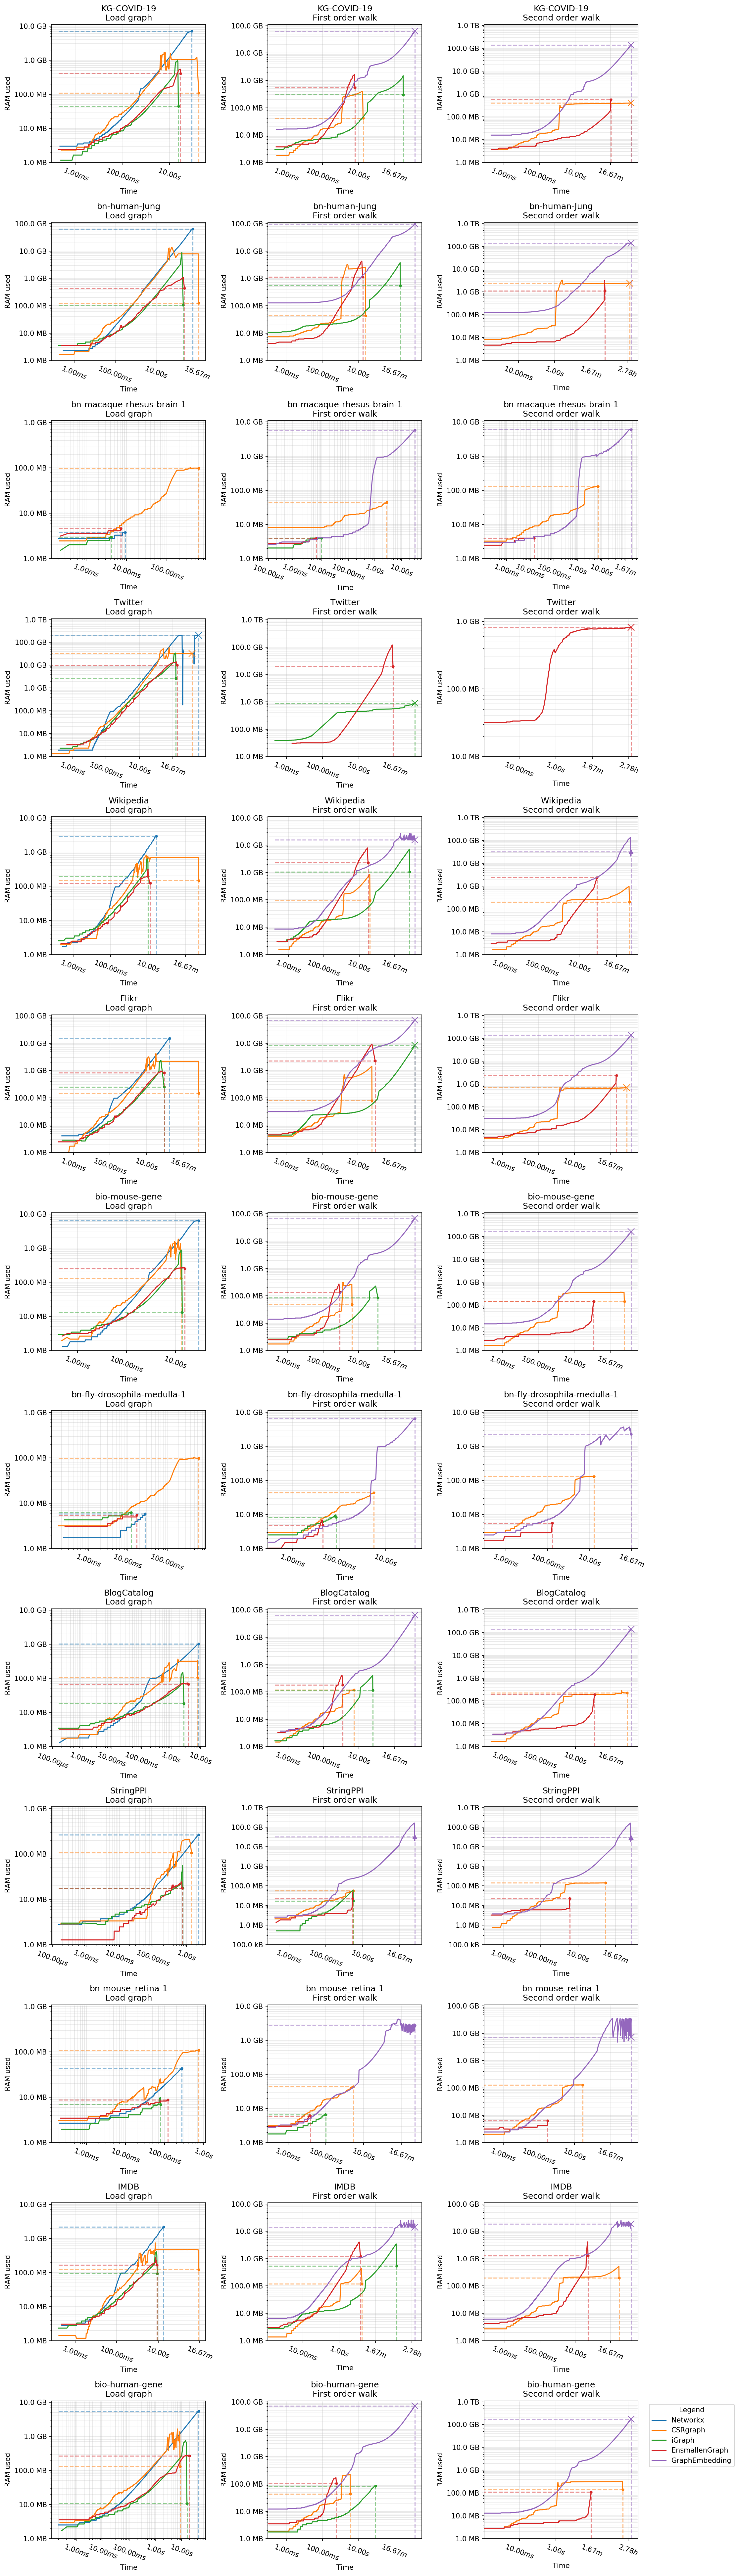

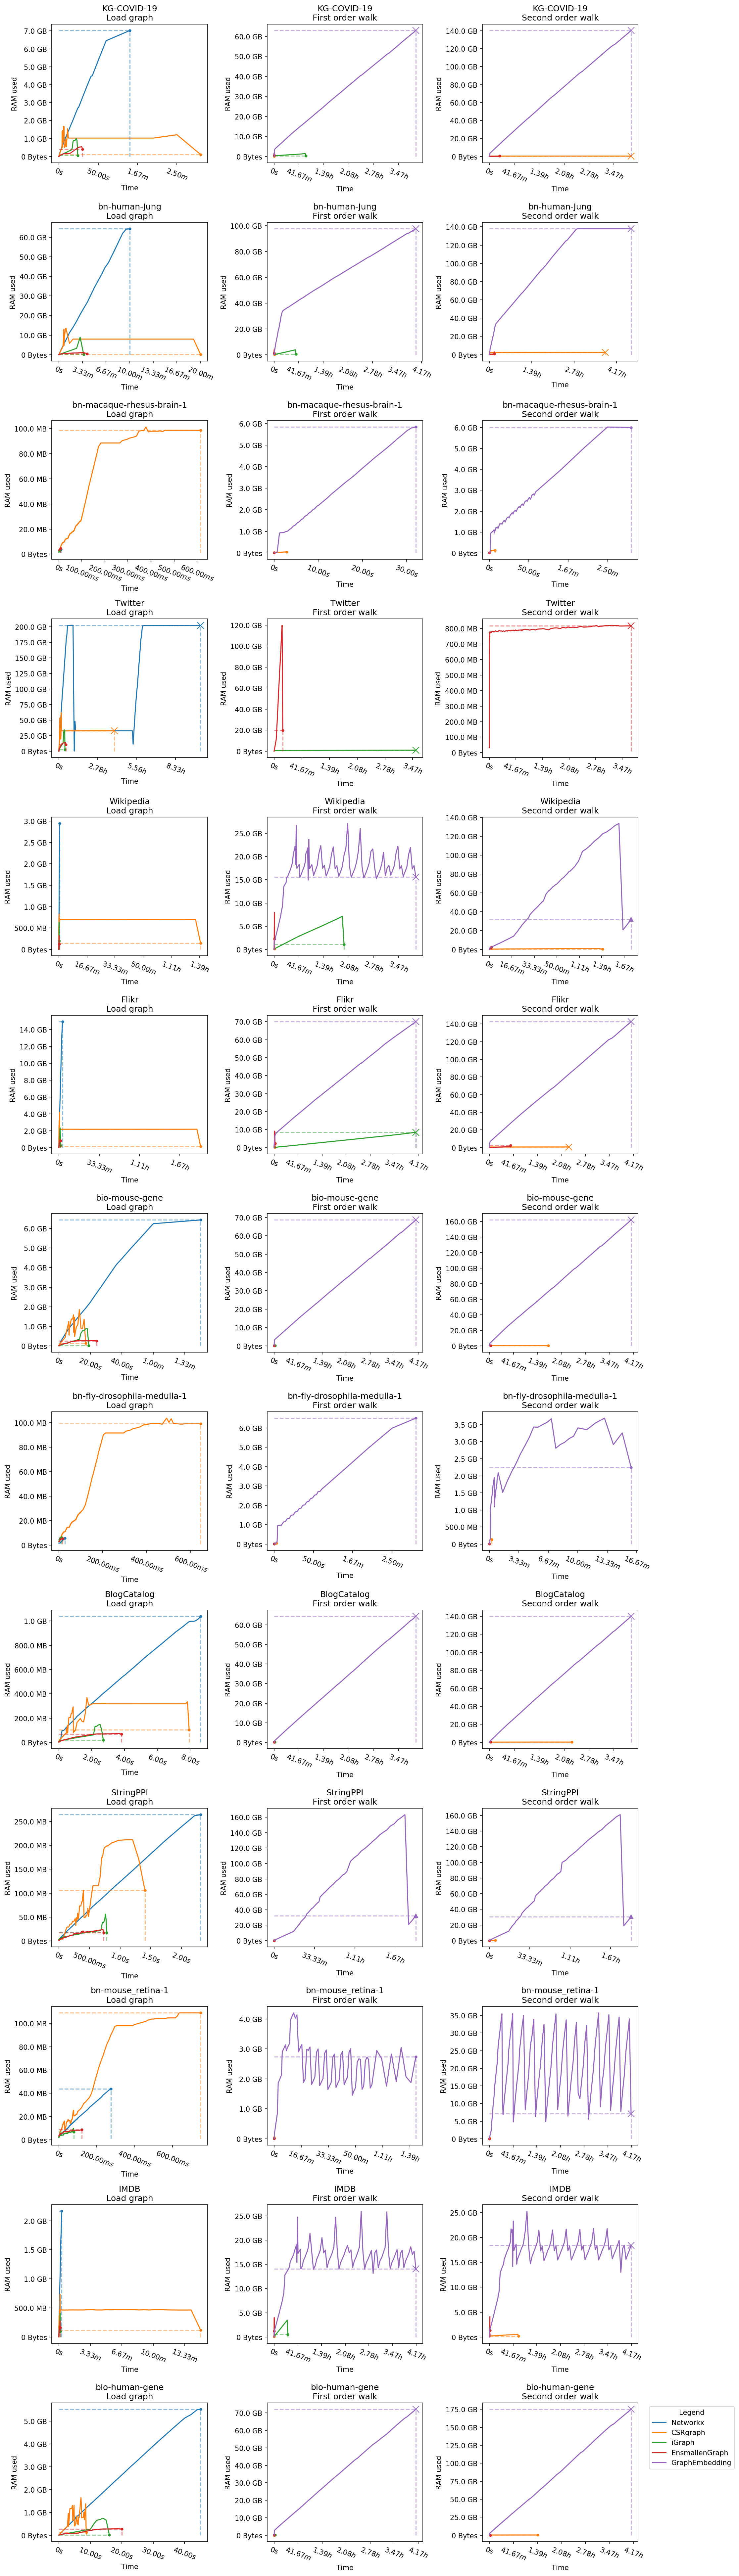

In [22]:
cmap = plt.get_cmap("tab10")
colors = dict(list(zip(result.library.unique(), cmap.colors)))
ncols=len(result.task.unique())
nrows=len(result.graph.unique())
    

for log in [True, False]:
    fig, axes = plt.subplots(
        dpi=150,
        ncols=ncols,
        nrows=nrows,
        squeeze=False,
        figsize=(5*ncols, 4*nrows)
    )
    for graph, sub_axes in zip(result.graph.unique(), axes):
        for task, axis in zip(tasks, sub_axes):
            all_data = result[(result.graph==graph) & (result.task==task)]
            max_y = 10**np.ceil(np.log10(all_data.memory.max()))
            min_y = all_data.memory.min()
            if min_y < 0.0001:
                min_y = 0.0001
                
            min_y = 10**np.floor(np.log10(min_y))
            max_x = all_data.time.max()
            min_x = all_data.time.min()
            for library in result.library.unique():
                # get the data for this triple (graph, task, library)
                filtered = all_data[(all_data.library==library)]
                if len(filtered):
                    # Plot the graph
                    axis.plot(filtered.time, filtered.memory, label=sanitize_ml_labels(library), c=colors[library])
                    x, y = filtered.time.iloc[-1], filtered.memory.iloc[-1]
                    # add the termination marker
                    exec_type = execs_type[graph][library][task]
                    if exec_type == "killed":
                        axis.plot([x], [y], marker="x", c=colors[library], markersize=10)
                    elif exec_type == "exception":
                        axis.plot([x], [y], marker="^", c=colors[library])
                    else:
                        axis.plot([x], [y], marker=".", c=colors[library])
                    # Draw the finish line
                    axis.plot([x, x], [min_y, y], "--", alpha=0.5, c=colors[library])
                    axis.plot([min_x, x], [y, y], "--", alpha=0.5, c=colors[library])
            if log:                    
                if not (np.isnan(min_y) or np.isnan(max_y)):
                    axis.set_ylim([min_y, max_y*1.1])
                axis.set_yscale('log')
                axis.set_xscale('log')
                axis.grid(True, which="both", ls="-", alpha=0.3)
            
            axis.set_xlabel("Time")
            axis.set_ylabel("RAM used")
            axis.xaxis.set_tick_params(rotation=-20)
            axis.xaxis.set_major_formatter(plt.FuncFormatter(xformat_func))
            axis.yaxis.set_major_formatter(plt.FuncFormatter(yformat_func))
            axis.set_title("{graph}\n{task}".format(
                graph=graph,
                task=sanitize_ml_labels(task)
            ))
            
                
    legend_without_duplicate_labels(fig, axes, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.set_facecolor('w')